# STEP 2 : DATA CLEANING
   WHAT: Fix problems and prepare data for ML<br>
   WHY:  Models need clean, consistent data<br>
   
   TASKS:<br>
   • Handle missing values (remove or impute)<br>
   • Remove duplicates<br>
   • Scale features (StandardScaler)<br>
   • Handle class imbalance (class weights)<br>
   • Train/test split (80/20, stratified)<br>
   
   OUTPUT: Clean dataset ready for modeling

In [1]:
import pandas as pd  # For working with tables/data
import numpy as np   # For mathematical operations
import matplotlib.pyplot as plt  # For creating graphs
import seaborn as sns  # For beautiful visualizations

In [2]:
df = pd.read_csv('01_combined_data.csv')

## 2.1 Remove labels & identifiers

### Purpose: Separate actual features from non-features Why: Labels are what we're trying to predict - including them would be cheating (data leakage). Identifiers like device names don't help predict attacks.

In [3]:
# Remove labels and identifiers
exclude = ['is_attack','label_full', 'label1', 'label2', 'label3', 'label4',
           'device_name', 'device_mac', 'timestamp', 'timestamp_start', 'timestamp_end']

feature_columns = [col for col in df.columns if col not in exclude]

print(f"Features: {len(feature_columns)}")

Features: 84


### Purpose: Filter to numeric data only Why: ML algorithms work with numbers, not text. Non-numeric columns (like IP addresses, MAC addresses) need special handling. What it does: Selects only columns with numeric data types (int, float)

In [4]:
# Keep only numeric features
numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")

Numeric features: 71


## 2.1 Remove ZERO VARIANCE

### Purpose: Remove features that never change Why: If a feature has the same value for all samples (variance=0), it provides no information for distinguishing benign from attack. Example: if all samples have protocol='TCP', it can't help predict anything.

In [5]:
# Remove zero variance
variances = df[numeric_features].var()
features = variances[variances > 0].index.tolist()
print(f"After removing zero variance: {len(features)}")

After removing zero variance: 71


## 2.2 Remove correlated features

### Purpose: Remove redundant features Why: If two features are 95%+ correlated, they provide the same information. Keeping both wastes computation and can cause model to overweight that information. What it does: Calculates correlation between all feature pairs. If correlation > 0.95, drops one of them.

In [6]:
# Remove highly correlated (>0.95)
corr = df[features].corr().abs()
to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] > 0.95:
            to_drop.add(corr.columns[j])

features = [f for f in features if f not in to_drop]
print(f"Final features: {len(features)}")
print(features)


Final features: 51
['log_data-ranges_avg', 'log_data-ranges_std_deviation', 'log_data-types_count', 'log_interval-messages', 'log_messages_count', 'network_fragmentation-score', 'network_fragmented-packets', 'network_header-length_avg', 'network_header-length_std_deviation', 'network_interval-packets', 'network_ip-flags_avg', 'network_ip-flags_max', 'network_ip-flags_min', 'network_ip-flags_std_deviation', 'network_ip-length_avg', 'network_ip-length_max', 'network_ip-length_min', 'network_ip-length_std_deviation', 'network_ips_all_count', 'network_ips_src_count', 'network_mss_avg', 'network_mss_std_deviation', 'network_packet-size_min', 'network_packets_all_count', 'network_packets_src_count', 'network_payload-length_std_deviation', 'network_ports_all_count', 'network_ports_dst_count', 'network_protocols_all_count', 'network_protocols_dst_count', 'network_protocols_src_count', 'network_tcp-flags-ack_count', 'network_tcp-flags-fin_count', 'network_tcp-flags-syn_count', 'network_tcp-flag

## 2.3  Best features selection

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
X = df[features]        # numeric feature data
y = df['is_attack']     # target

# Train the model
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)

# Show full ranking
print("Feature ranking:\n", feat_importances)


Feature ranking:
 network_packets_all_count               0.147891
network_time-delta_min                  0.116547
network_ports_all_count                 0.102551
network_packet-size_min                 0.084308
network_ports_dst_count                 0.062098
network_time-delta_avg                  0.043901
network_packets_src_count               0.043719
network_tcp-flags-syn_count             0.033677
network_tcp-flags-ack_count             0.029226
network_time-delta_max                  0.024135
network_mss_avg                         0.022800
network_tcp-flags_std_deviation         0.020819
network_interval-packets                0.018665
network_window-size_std_deviation       0.016516
network_time-delta_std_deviation        0.015970
network_window-size_avg                 0.015556
network_ips_all_count                   0.014607
network_ips_src_count                   0.014190
network_ip-length_avg                   0.013882
network_window-size_max                 0.013619
ne

# 2.4 : final selected features

Features needed: 90%=24, 95%=31, 99%=41


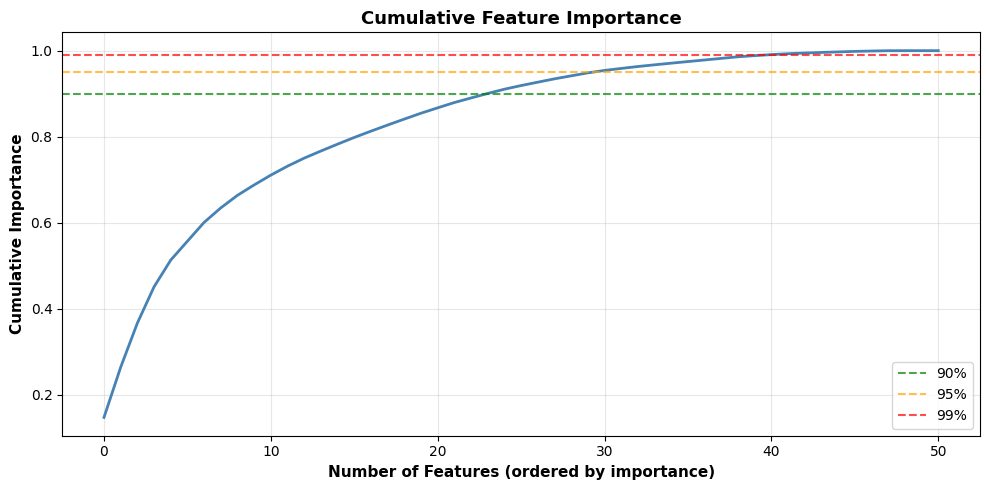

In [12]:
# ============================================
# CUMULATIVE FEATURE IMPORTANCE
# ============================================

import matplotlib.pyplot as plt

cumulative_importance = feat_importances.cumsum()

# Find thresholds
n_90 = (cumulative_importance <= 0.90).sum() + 1
n_95 = (cumulative_importance <= 0.95).sum() + 1
n_99 = (cumulative_importance <= 0.99).sum() + 1

print(f"Features needed: 90%={n_90}, 95%={n_95}, 99%={n_99}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_importance.values, linewidth=2, color='steelblue')

# Threshold lines
plt.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
plt.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
plt.axhline(y=0.99, color='red', linestyle='--', alpha=0.7, label='99%')

plt.xlabel('Number of Features (ordered by importance)', fontsize=11, fontweight='bold')
plt.ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
plt.title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [13]:
# Keep features until 95% cumulative importance
final_features = cumulative_importance[cumulative_importance <= 0.99].index.tolist()

# Make sure all selected features exist in the dataframe
final_features = [f for f in final_features if f in df.columns]

# Create X with only the final features
X = df[final_features]
y = df['is_attack']

print("Final features to use:", final_features)
print("Shape of X:", X.shape)


Final features to use: ['network_packets_all_count', 'network_time-delta_min', 'network_ports_all_count', 'network_packet-size_min', 'network_ports_dst_count', 'network_time-delta_avg', 'network_packets_src_count', 'network_tcp-flags-syn_count', 'network_tcp-flags-ack_count', 'network_time-delta_max', 'network_mss_avg', 'network_tcp-flags_std_deviation', 'network_interval-packets', 'network_window-size_std_deviation', 'network_time-delta_std_deviation', 'network_window-size_avg', 'network_ips_all_count', 'network_ips_src_count', 'network_ip-length_avg', 'network_window-size_max', 'network_ttl_avg', 'network_window-size_min', 'network_ip-length_std_deviation', 'network_ip-length_max', 'network_ip-flags_std_deviation', 'network_ttl_std_deviation', 'network_ttl_min', 'network_tcp-flags_avg', 'network_payload-length_std_deviation', 'network_ip-length_min', 'network_ip-flags_avg', 'network_header-length_avg', 'network_protocols_dst_count', 'network_fragmentation-score', 'network_ttl_max', '

### Save cleaned data

This cell selects the final features and target columns, then saves the cleaned
dataset as `02_cleaned_data.csv`.  
This file is ready to be used for model training.


In [14]:
# ============================================
# SAVE CLEANED DATA FOR MODELING
# ============================================

import pickle

print("\n" + "="*80)
print("💾 SAVING CLEANED DATA")
print("="*80)

# Save the cleaned dataframe with selected features
df_clean = df[final_features + ['is_attack', 'label2']].copy()  # Keep targets
df_clean.to_csv('02_cleaned_data.csv', index=False)


print(f"\n✅ Saved cleaned dataset: 02_cleaned_data.csv")
print(f"   - Shape: {df_clean.shape}")
print(f"   - Features: {len(final_features)}")
print(f"   - Targets: is_attack, label2")


print("\n" + "="*80)
print("🎯 READY FOR MODELING!")
print("="*80)







💾 SAVING CLEANED DATA

✅ Saved cleaned dataset: 02_cleaned_data.csv
   - Shape: (685671, 42)
   - Features: 40
   - Targets: is_attack, label2

🎯 READY FOR MODELING!
